In [1]:
import os
import sys
import pandas as pd
import glob
import shutil
import numpy as np
from os.path import split, splitext, join

base_dir = os.path.realpath('D:\\sky_dataset')

In [2]:
#all_img_df = pd.DataFrame(dict(path = glob.glob(os.path.join(base_dir,'sky_image','10066', '*.jpg*'))))
path = []
for num in sorted(os.listdir(os.path.join(base_dir,'sky_image'))):
    path += glob.glob(os.path.join(base_dir,'sky_image',num, '*.jpg*'))
all_img_df = pd.DataFrame(dict(path = path))


In [3]:
import re
counter = 0
mask_path = []
id = [] 
for x in path:
    num = (re.findall('\d+', x ))
    id.append(num[0])
    mask_path += glob.glob(os.path.join(base_dir, 'sky_mask', str(num[0]) + '.png'))

all_img_df["sky_mask"] = mask_path
all_img_df["id"] = id


In [4]:
all_img_df["key_id"] = all_img_df['path'].map(lambda x : splitext(os.path.basename(x))[0])
all_img_df['sky_id'] = all_img_df['key_id'].map(lambda x: x.split('_')[1])
all_img_df.head()
from sklearn.model_selection import train_test_split
def train_test_split_on_group(in_df, col_id, **kwargs):
    group_val = np.unique(in_df[col_id])
    train_ids, test_ids = train_test_split(group_val, **kwargs)
    return in_df[in_df[col_id].isin(train_ids)], in_df[in_df[col_id].isin(test_ids)]

train_df, valid_df = train_test_split_on_group(all_img_df, col_id='sky_id', random_state=2018,test_size=0.1)
valid_df, test_df = train_test_split_on_group(valid_df, col_id = 'sky_id', random_state = 2018, test_size = 0.5)
print(train_df.shape[0], 'training images')
print(valid_df.shape[0], 'validation images')
print(test_df.shape[0], 'test images')
all_img_df.head()

67689 training images
3924 validation images
3756 test images


,path,sky_mask,id,key_id,sky_id
0,D:\sky_dataset\sky_image\10066\20130101_084634...,D:\sky_dataset\sky_mask\10066.png,10066,20130101_084634,084634
1,D:\sky_dataset\sky_image\10066\20130101_091628...,D:\sky_dataset\sky_mask\10066.png,10066,20130101_091628,091628
2,D:\sky_dataset\sky_image\10066\20130101_114638...,D:\sky_dataset\sky_mask\10066.png,10066,20130101_114638,114638
3,D:\sky_dataset\sky_image\10066\20130101_125725...,D:\sky_dataset\sky_mask\10066.png,10066,20130101_125725,125725
4,D:\sky_dataset\sky_image\10066\20130101_154632...,D:\sky_dataset\sky_mask\10066.png,10066,20130101_154632,154632


In [57]:
#Augmentation of data
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

dg_args = dict(featurewise_center = False,
              samplewise_center = False,
              rotation_range = 5,
              width_shift_range = 0.01,
              height_shift_range = 0.01,
              shear_range = 0.01,
              zoom_range = [0.9, 1.1],
              horizontal_flip = True,
              vertical_flip = False,
              fill_mode = 'nearest',
              data_format = 'channels_last',
              preprocessing_function = preprocess_input)

IMG_SIZE = (256,256)
default_batch_size = 8
dg_args['preprocessing_function'] = lambda x:x/255.0
core_idg = ImageDataGenerator(**dg_args)
mask_args = dg_args.copy()
#mask_args['preprocessing_function'] = lambda x:x/255.0
mask_idg = ImageDataGenerator(**mask_args)

In [58]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode='sparse', **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    print(np.stack(in_df[y_col].values))
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [59]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def make_gen(img_gen, mask_gen, in_df, batch_size = default_batch_size, seed=None, shuffle=True):
    if seed is None:
        seed = np.random.choice(range(9999))
    flow_args = dict(target_size = IMG_SIZE,
                    batch_size = batch_size,
                    seed = seed,
                    shuffle = shuffle,
                    y_col = 'key_id')
    t0_gen = flow_from_dataframe(img_gen, in_df,
                                 path_col = 'path',
                                color_mode = 'rgb',
                                **flow_args)
    dm_gen = flow_from_dataframe(mask_gen, in_df,
                                path_col = 'sky_mask',
                                color_mode = 'grayscale',
                                **flow_args)
    
    for (t0_img, _), (dm_img, _) in zip(t0_gen, dm_gen):
        yield [t0_img], dm_img
train_gen = make_gen(core_idg, mask_idg, train_df)
valid_gen = make_gen(core_idg, mask_idg, valid_df, seed=0, shuffle= False)
test_gen = make_gen(core_idg, mask_idg, test_df, seed=0, shuffle=False, batch_size =2*default_batch_size)
[t0_img], dm_img = next(train_gen)

print(t0_img.shape, t0_img.max())
print(dm_img.shape, dm_img.max(), dm_img.mean())

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
['20130101_091628' '20130101_114638' '20130101_125725' ...
 '20131231_105659' '20131231_162701' '20131231_235702']
Reinserting dataframe: 67689 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
['20130101_091628' '20130101_114638' '20130101_125725' ...
 '20131231_105659' '20131231_162701' '20131231_235702']
Reinserting dataframe: 67689 images
(8, 256, 256, 3) 1.0
(8, 256, 256, 1) 1.0 0.27746454


(8, 256, 256, 1)


Text(0.5,1,'$\\Delta$T Mask')

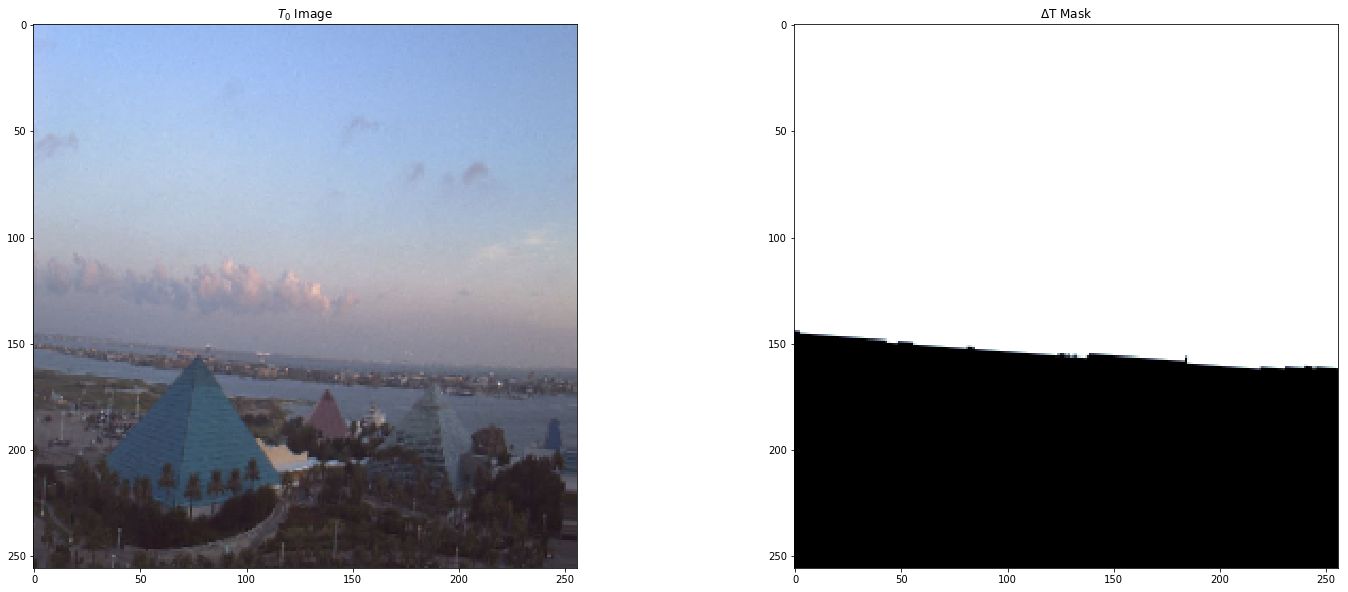

In [60]:
import matplotlib.pyplot as plt
#import skimage
#from skimage.util.montage import montage2d
#n_rgb = lambda x: np.stack([(x[:, :, i]-x[:, :, i].min())/(x[:, :, i].max()-x[:, :, i].min()) for i in range(x.shape[2])], 2)[:, :, ::-1]
#nn_rgb = lambda x: n_rgb(np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1))
print(dm_img.shape)
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (25, 10))
ax1.imshow((t0_img[5, :, :, :].reshape(256,256,3)), cmap = 'bone')
ax1.set_title('$T_0$ Image')
ax3.imshow((dm_img[5, :, :, :].reshape(256,256)), cmap = 'bone')
ax3.set_title('$\Delta$T Mask')

In [61]:
#building the model
from keras.applications.vgg16 import VGG16 as PTModel
base_pretrained_model = PTModel(input_shape = t0_img.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

In [62]:
from collections import defaultdict, OrderedDict
from keras.models import Model
layer_size_dict = defaultdict(list)
inputs = []
for lay_idx, c_layer in enumerate(base_pretrained_model.layers):
    if not c_layer.__class__.__name__ == 'InputLayer':
        layer_size_dict[c_layer.get_output_shape_at(0)[1:3]] += [c_layer]
    else:
        inputs +=[c_layer]
layer_size_dict = OrderedDict(layer_size_dict.items())
for k,v in layer_size_dict.items():
    print(k, [w.__class__.__name__ for w in v])            

(256, 256) ['Conv2D', 'Conv2D']
(128, 128) ['MaxPooling2D', 'Conv2D', 'Conv2D']
(64, 64) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(32, 32) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(16, 16) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(8, 8) ['MaxPooling2D']


In [63]:
#tahe the last layer in each shape and make it into an output
pretrained_encoder = Model(inputs = base_pretrained_model.get_input_at(0), outputs = [v[-1].get_output_at(0) for k,v in layer_size_dict.items()])
pretrained_encoder.trainable = False
n_outputs = pretrained_encoder.predict([t0_img])
for c_out, (k,v) in zip(n_outputs, layer_size_dict.items()):
    print(c_out.shape, 'expected', k)

(8, 256, 256, 64) expected (256, 256)
(8, 128, 128, 128) expected (128, 128)
(8, 64, 64, 256) expected (64, 64)
(8, 32, 32, 512) expected (32, 32)
(8, 16, 16, 512) expected (16, 16)
(8, 8, 8, 512) expected (8, 8)


In [154]:
from keras.layers import Input, Conv2D, concatenate, UpSampling2D, BatchNormalization, Activation, Cropping2D, ZeroPadding2D
x_wid, y_wid = t0_img.shape[1:3]
in_t0 = Input(t0_img.shape[1:], name = 'T0_Image')
wrap_encoder = lambda i_layer: {k:v for k,v in zip(layer_size_dict.keys(), pretrained_encoder(i_layer))}
t0_outputs = wrap_encoder(in_t0)
lay_dims = sorted(t0_outputs.keys(), key=lambda x:x[0])
skip_layers = 2
last_layer = None

for k in lay_dims[skip_layers:]:
    cur_layer = t0_outputs[k]
    channel_count = cur_layer._keras_shape[-1]
    cur_layer = Conv2D(channel_count//2, kernel_size=(3,3), padding='same', activation='linear')(cur_layer)
    cur_layer = BatchNormalization()(cur_layer) # gotta keep an eye on that internal covariant shift
    cur_layer = Activation('relu')(cur_layer)
    
    if last_layer is None:
        x = cur_layer
    else:
        last_channel_count = last_layer._keras_shape[-1]
        x = Conv2D(last_channel_count//2, kernel_size=(3,3), padding = 'same')(last_layer)
        x = UpSampling2D((2,2))(x)
        x = concatenate([cur_layer, x])
    last_layer = x
final_output = Conv2D(dm_img.shape[-1], kernel_size=(1,1), padding='same', activation='sigmoid')(last_layer)
crop_size = 20
#final_output = Cropping2D((crop_size, crop_size))(final_output)
#final_output = ZeroPadding2D((crop_size, crop_size))(final_output)

unet_model = Model(inputs = [in_t0],
                   outputs = [final_output])

unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T0_Image (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_9 (Model)                 [(None, 256, 256, 64 14714688    T0_Image[0][0]                   
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 32, 32, 256)  1179904     model_9[2][3]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 32, 32, 256)  1024        conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_42 

In [65]:
#unet_model.load_weights('vgg_unet_weights.best.hdf5')

In [66]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
def dice_p_bce(in_gt, in_pred):
    return 1 - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

unet_model.compile(optimizer=Adam(1e-4, decay = 1e-6), 
                   loss=dice_p_bce, 
                   metrics=[dice_coef, 'binary_accuracy'])
loss_history = []
    

In [67]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('vgg_unet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.00001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

C:\Anaconda3\envs\dl\lib\site-packages\keras\callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [68]:
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

loss_history += [unet_model.fit_generator(make_gen(core_idg, mask_idg, train_df), 
                                             steps_per_epoch=min(100, train_df.shape[0]//t0_img.shape[0]), 
                                             epochs = 5, 
                                             validation_data = valid_gen,
                                              validation_steps = valid_df.shape[0]//t0_img.shape[0],
                                             callbacks = callbacks_list,
                                              workers = 2,
                                              )]


## Ignore next message from keras, values are replaced anyways
Epoch 1/5
Found 0 images belonging to 0 classes.
['20130101_091628' '20130101_114638' '20130101_125725' ...
 '20131231_105659' '20131231_162701' '20131231_235702']
Reinserting dataframe: 67689 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
['20130101_091628' '20130101_114638' '20130101_125725' ...
 '20131231_105659' '20131231_162701' '20131231_235702']
Reinserting dataframe: 67689 images
 99/100 [============================>.] - ETA: 0s - loss: 0.1034 - dice_coef: 0.8966 - binary_accuracy: 0.7628## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
['20130106_085727' '20130108_115731' '20130109_064638' ...
 '20131229_155706' '20131231_035703' '20131231_052708']
Reinserting dataframe: 3924 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
['20130106_085727' 

KeyError: 'true_positive_rate'

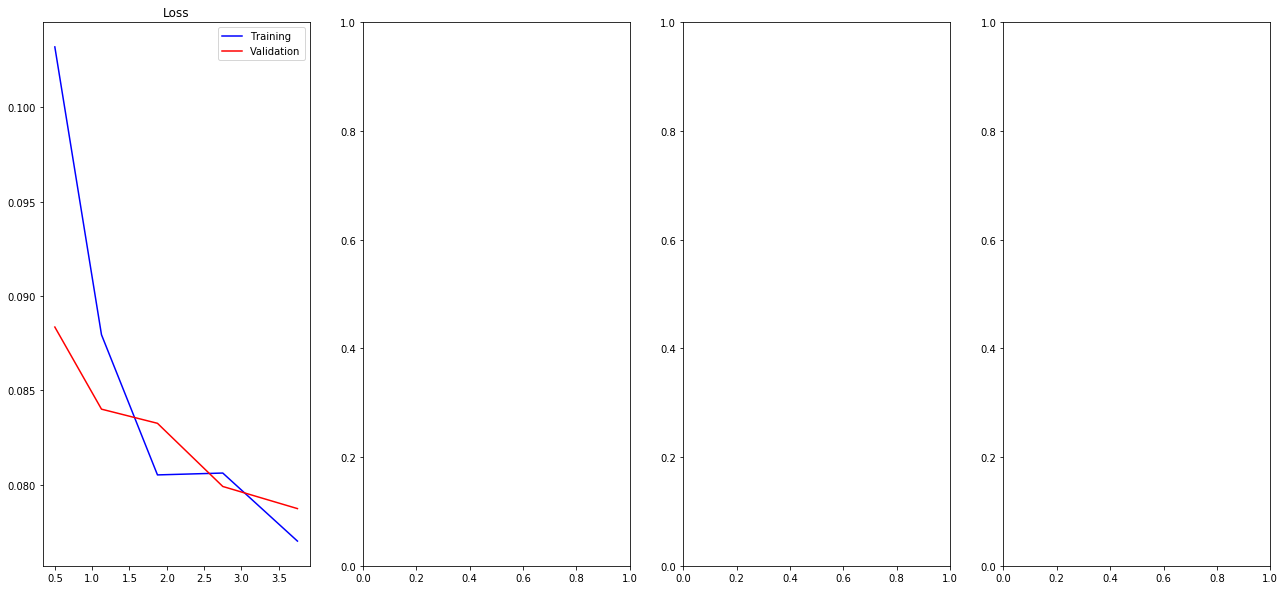

In [69]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [174]:
from keras.models import load_model
unet_model = load_model('unet_sky_model.h5')
unet_model.load_weights('vgg_unet_weights.best_sky.hdf5')

C:\Anaconda3\envs\dl\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[[5.9570648e-06 1.6209828e-05 8.3700527e-08 ... 3.0320771e-03
  3.2139383e-03 3.2174108e-03]
 [1.3415303e-05 3.2549906e-05 1.4710395e-07 ... 8.0065355e-03
  8.4885499e-03 8.4137255e-03]
 [7.2638208e-08 1.6685696e-07 3.3926556e-11 ... 8.4484750e-03
  8.8544618e-03 8.7322779e-03]
 ...
 [5.1458223e-08 1.4908174e-07 4.8642645e-10 ... 9.9221802e-01
  9.9218267e-01 9.9226272e-01]
 [6.2411885e-08 1.8140778e-07 6.5444344e-10 ... 9.9330068e-01
  9.9302703e-01 9.9304730e-01]
 [6.2533431e-08 1.8199488e-07 6.6728895e-10 ... 9.9319881e-01
  9.9263257e-01 9.9260324e-01]]
float32


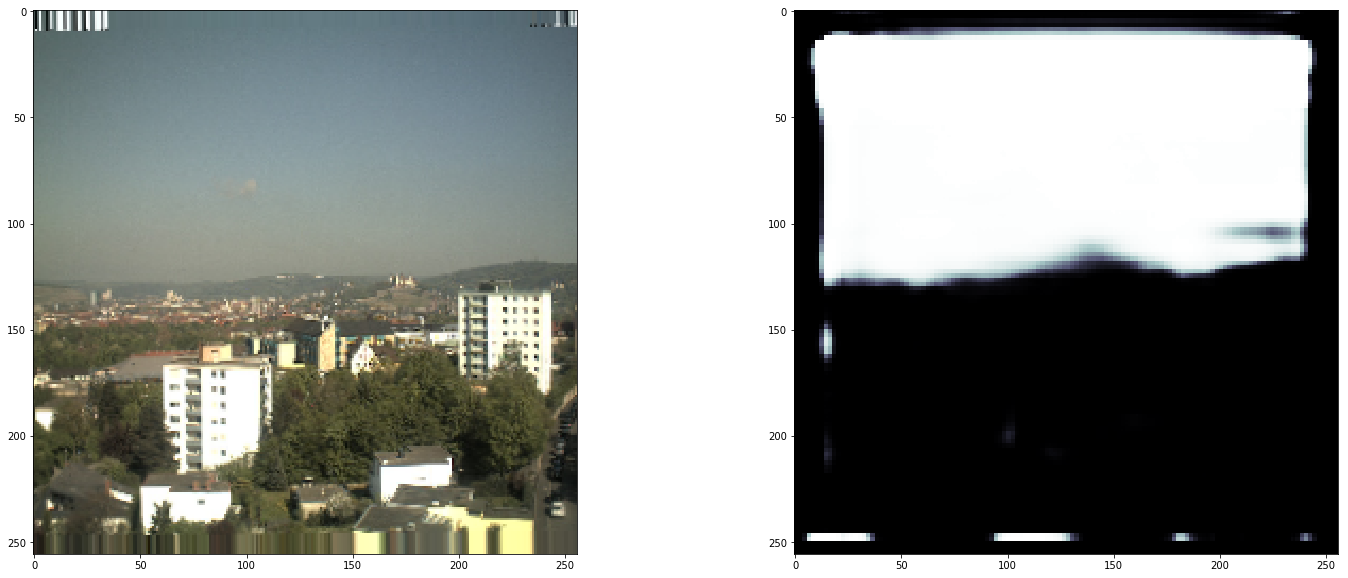

In [175]:
[t0_img], dm_img = next(test_gen)
dm_pred = unet_model.predict([t0_img])
print((dm_pred[5,0:100,0:100,0]))
print(t0_img.dtype)
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (25, 10))
ax1.imshow((t0_img[5, :, :, :].reshape(256,256,3)), cmap = 'bone')
ax3.imshow(np.reshape(dm_pred[5,:,:,0],[256,256]), cmap = 'bone')

In [124]:
from PIL import Image
j = Image.fromarray((dm_pred[5,:,:,:].reshape(256,256)))
j.save("sky.tiff")

In [125]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import os
from scipy.misc import imresize
from PIL import Image
path = os.getcwd()
original_img = load_img(os.path.join(path,'catdog.jpg'))
i = imresize(original_img,[512,512,3])
resized_img = np.reshape(i,[1,512,512,3])
dims = [512, 512]
#resized_img = tf.reshape(i, [1,512,512,3])
print(resized_img.shape)
dm_pred = unet_model.predict(resized_img)
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (25, 10))
ax1.imshow((resized_img.reshape(512,512,3)), cmap = 'bone')
ax3.imshow((dm_pred[:,:,:,:].reshape(512,512)), cmap = 'bone')   

ValueError: cannot reshape array of size 65536 into shape (512,512)

In [166]:
unet_model.save('unet_sky_model.h5')